# Augmentation Base Model (Transfer Learning, EfficientNetB0)

In [1]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import keras
from tensorflow.keras import layers, models

/Users/Temp/Data4380/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
#dataloader module
import Vision_Dataloader as vd

In [13]:
#reimport if necessary (edit file after already imported)
import importlib
importlib.reload(vd)

<module 'Vision_Dataloader' from '/Users/Temp/Data4380/Image Project - Watch Dataset/Vision_Dataloader.py'>

## Transfer Learning (EfficientNetB0); Target = [Hour][Minute]
* Augmentation
* Standardization
* image size (224, 224) for EfficientNetB0
* Images = 1000
* Batches = 64
* Epochs = 25

In [3]:
train_ds,val_ds,targetstats=vd.image_loader('watch_faces_train.parquet',target='list',batches=64,augmentation=True,standardize=True,img_size=(224, 224))

In [4]:
#checking correct tensor shape
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [5]:
def make_transfer_model(input_shape):
    backbone = keras.applications.EfficientNetB0(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    backbone.trainable = True
    for layer in backbone.layers[:-50]:
        layer.trainable = False

    inputs = layers.Input(input_shape)
    #x = keras.applications.efficientnet.preprocess_input(inputs) #incorporated in dataloader module
    x = backbone(inputs)
    x = layers.Dropout(0.3)(x)
    
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.25)(x)
    
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)

    outputs = layers.Dense(2, activation='linear')(x)

    return keras.Model(inputs, outputs, name="Tell_Time")

In [6]:
epochs = 25

callbacks = [
    #keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

model=make_transfer_model(input_shape=(224, 224, 3))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4),loss='mse',metrics=['mae'])

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 1.0904 - mae: 0.8887 - val_loss: 1.0416 - val_mae: 0.8773
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 1.0222 - mae: 0.8671 - val_loss: 1.0327 - val_mae: 0.8748
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.9474 - mae: 0.8348 - val_loss: 1.0154 - val_mae: 0.8642
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.8985 - mae: 0.8065 - val_loss: 1.0124 - val_mae: 0.8705
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 930ms/step - loss: 0.8643 - mae: 0.7899 - val_loss: 1.0175 - val_mae: 0.8634
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 990ms/step - loss: 0.8299 - mae: 0.7735 - val_loss: 1.0165 - val_mae: 0.8629
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 932ms/step - loss: 0.8252 - mae: 0.7652 - val_loss: 0.9671 - val_mae: 0.8278
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 911ms/step - loss: 0.7383 - mae: 0.7198 - val_loss: 0.9102 - val_mae: 0.7958
Epoch 9/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 911ms/step - loss:

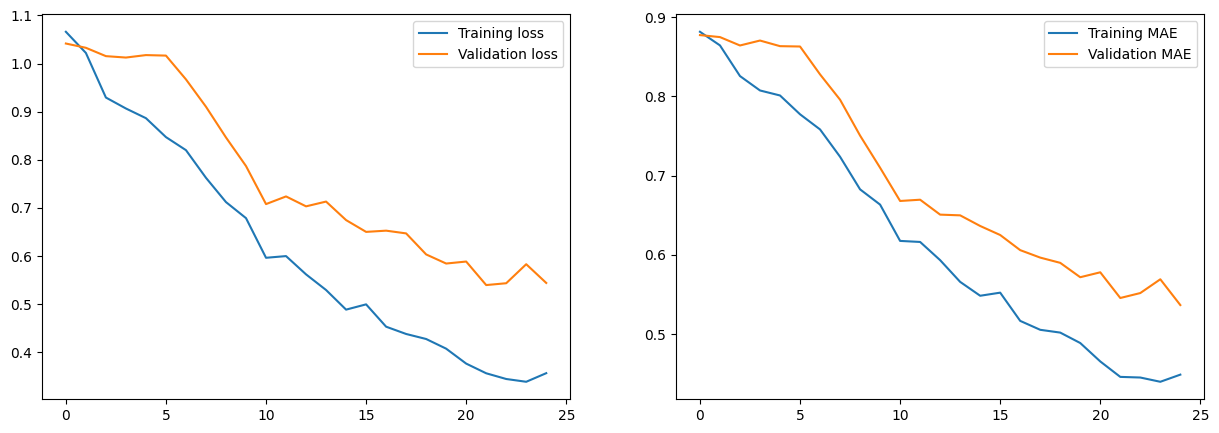

In [7]:
plt.figure(figsize=(15, 5))


plt.subplot(1, 2, 1)
#mean squared error
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation loss")
plt.legend()

plt.subplot(1, 2, 2)
#mean absolute error
plt.plot(range(len(history.history['mae'])),history.history['mae'],label="Training MAE")
plt.plot(range(len(history.history['val_mae'])),history.history['val_mae'],label="Validation MAE")
plt.legend()

2025-07-18 18:38:18.980465: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


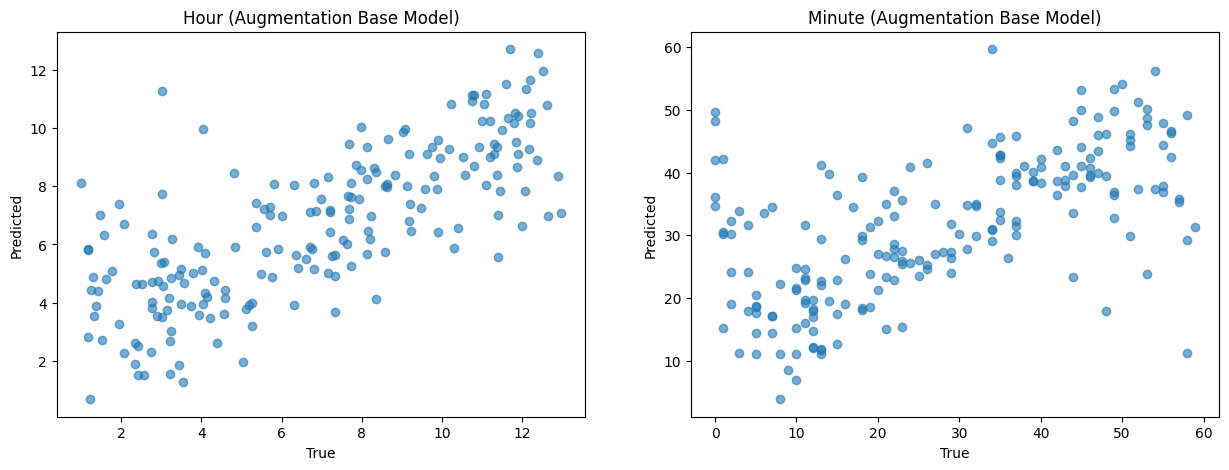

In [8]:
base_true=[]
base_pred=[]
for image, label in val_ds.unbatch():
    image=tf.expand_dims(image,axis=0)
    pred=model.predict(image,verbose=0)[0]
    base_pred.append(pred)
    base_true.append(label.numpy())

base_true=np.array(base_true)
base_pred=np.array(base_pred)

plt.figure(figsize=(15, 5))

#hour
plt.subplot(1, 2, 1)
plt.scatter(base_true[:,0]*targetstats['Hour']['std']+targetstats['Hour']['mean'], base_pred[:,0]*targetstats['Hour']['std']+targetstats['Hour']['mean'], alpha=0.6)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Hour (Augmentation Base Model)')

#minute
plt.subplot(1, 2, 2)
plt.scatter(base_true[:,1]*targetstats['Minute']['std']+targetstats['Minute']['mean'], base_pred[:,1]*targetstats['Minute']['std']+targetstats['Minute']['mean'], alpha=0.6)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Minute (Augmentation Base Model)')

plt.show()

In [9]:
model.save('AugBaseModel.keras')

### Notes for Augmenatation Base Model
* loss graph was showing curve towards 0; hopefully more epochs will allow a closer validation loss to get closer to training loss
* MAE = 0.5366 (worse than No Augmentation Base Model; MAE = 0.4909)
* No Augmentation Base Model having a better MAE value is supported by the scatter plots comparing the predict and true values of Hour and Mintues
    * Datapoints in this notebook's scatterplots are more spread out, while the datapoints in the other notebook are tighter to the x=y line